In [1]:
import tensorflow as tf


class NALU(tf.keras.Model):
    def __init__(self, input_shape, output_shape):
        super(NALU, self).__init__(name='')
        self.eps = 1e-7
        W_shape = (input_shape, output_shape)
        self.W_hat = tf.Variable(tf.random.truncated_normal(W_shape, stddev=0.02))
        self.M_hat = tf.Variable(tf.random.truncated_normal(W_shape, stddev=0.02))
        self.gate = tf.Variable(tf.random.truncated_normal(W_shape, stddev=0.02))

    def call(self, input_tensor, training=False, mask=None):
        # NAC cell
        self.W = tf.tanh(self.W_hat) * tf.sigmoid(self.M_hat)
        a = tf.matmul(input_tensor, self.W)
        # NALU
        m = tf.exp(tf.matmul(tf.math.log(tf.abs(input_tensor) + self.eps), self.W))
        g = tf.sigmoid(tf.matmul(input_tensor, self.gate))
        out = g * a + (1 - g) * m
        return out

In [2]:
def create_mlp(input_shape, output_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(8, input_shape=(input_shape,)))
    model.add(tf.keras.layers.Dense(8))
    model.add(tf.keras.layers.Dense(output_shape))
    
    return model

In [3]:
class Block(tf.keras.Model):
    def __init__(self, input_shape, output_shape):
        super(Block, self).__init__(name='')
        self.W = tf.Variable(tf.zeros((input_shape, output_shape)))
        # self.W_log = tf.Variable(tf.zeros((input_shape, output_shape)))
        # self.gate = tf.Variable([[0.], [0.], [1.]])
        self.gate = tf.Variable(tf.random.truncated_normal((self.W.shape[0], self.W.shape[-1]), stddev=0.02))

    def call(self, input_tensor, training=False, mask=None):
        x = input_tensor
        shift = 0
        _g = self.gate
        _W = self.W
        # g = self.gate
        _W1 = tf.multiply(_W, _g)
        x_1 = tf.matmul(x, _W1)

        x_2 = tf.math.log(x + shift)
        _W2 = tf.multiply(_W, -_g + 1)
        x_2 = tf.matmul(x_2, _W2)
        x_2 = tf.math.exp(x_2) - shift

        # g = tf.sigmoid(self.gate)
        # print(x_1)
        # print(g)
        # x_1 = tf.multiply(x_1, g)
        # x_2 = tf.multiply(x_2, (-g + 1))

        # g = tf.sigmoid(tf.matmul(input_tensor, self.gate))
        # _gate = tf.nn.sigmoid(self.gate)
        # x_1 = tf.multiply(g, x_1)
        # x_2 = tf.multiply((-g + 1), x_2)

        x = x_1 + x_2
        return x

In [4]:
from itertools import product
import numpy as np
import pandas as pd

np.random.seed(123)
tf.random.set_seed(123)

data_size = 10000
a = np.random.uniform(0, 10, data_size).reshape((data_size, 1))
b = np.random.uniform(0, 10, data_size).reshape((data_size, 1))
c = np.random.uniform(0, 10, data_size).reshape((data_size, 1))

# answer = np.array(list(product(a, b, c)))
answer = np.concatenate([a, b, c], axis=1)
print(answer.shape)
# print(answer)


df = pd.DataFrame(answer, columns=['a', 'b', 'c'])
df['a + 2b'] = df['a'] + 2 * df['b']
df['a * b'] = df['a'] * df['b']
df['a * b ^ 2 + c'] = df['a'] * (df['b'] ** 2) + df['c']
df['a / b + c'] = df['a'] / df['b'] + df['c']
df['(a + b) * c'] = (df['a'] + df['b']) * df['c']
df['a * b * c'] = df['a'] * df['b'] * df['c']
df = df.astype(np.float32)



(10000, 3)


In [4]:

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df[df.columns] = scaler.fit_transform(df[df.columns])
# df.head(10)


from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, test_size=0.2, random_state=123)

input_columns = ['a', 'b', 'c']
train_X = train[input_columns].values
valid_X = valid[input_columns].values

# target_columns = ['a + b', 'a * b']
target_columns = ['a + 2b', 'a * b', 'a * b ^ 2 + c', 'a / b + c', 'a * b * c'] #, '(a + b) * c'
# target_columns = ['(a + b) * c']
train_y = train[target_columns].values
valid_y = valid[target_columns].values


model = create_mlp(len(input_columns), len(target_columns))
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
history = model.fit(train_X, train_y, validation_data=(valid_X, valid_y), epochs=300)

y_pred = model.predict(valid_X[:5])

(10000, 3)
Train on 8000 samples, validate on 2000 samples
Epoch 1/300
8000/8000 [==============================] - 1s 119us/sample - loss: 18852.4643 - mse: 18852.4609 - val_loss: 12533.6531 - val_mse: 12533.6523
Epoch 2/300
8000/8000 [==============================] - 1s 65us/sample - loss: 8864.1941 - mse: 8864.1963 - val_loss: 6766.3419 - val_mse: 6766.3418
Epoch 3/300
8000/8000 [==============================] - 0s 58us/sample - loss: 7037.4336 - mse: 7037.4297 - val_loss: 6245.3331 - val_mse: 6245.3325
Epoch 4/300
8000/8000 [==============================] - 0s 62us/sample - loss: 6560.4418 - mse: 6560.4414 - val_loss: 5845.7112 - val_mse: 5845.7090
Epoch 5/300
8000/8000 [==============================] - 0s 59us/sample - loss: 6171.6988 - mse: 6171.6987 - val_loss: 5525.1424 - val_mse: 5525.1436
Epoch 6/300
8000/8000 [==============================] - 0s 59us/sample - loss: 5865.4891 - mse: 5865.4893 - val_loss: 5259.5743 - val_mse: 5259.5732
Epoch 7/300
8000/8000 [=============

Epoch 55/300
8000/8000 [==============================] - 0s 57us/sample - loss: 3223.3542 - mse: 3223.3540 - val_loss: 2907.6289 - val_mse: 2907.6292
Epoch 56/300
8000/8000 [==============================] - 1s 65us/sample - loss: 3224.7477 - mse: 3224.7478 - val_loss: 2915.0275 - val_mse: 2915.0273
Epoch 57/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3222.9972 - mse: 3222.9966 - val_loss: 2906.7876 - val_mse: 2906.7883
Epoch 58/300
8000/8000 [==============================] - 0s 61us/sample - loss: 3225.9496 - mse: 3225.9509 - val_loss: 2907.0094 - val_mse: 2907.0100
Epoch 59/300
8000/8000 [==============================] - 0s 58us/sample - loss: 3223.8592 - mse: 3223.8596 - val_loss: 2923.2624 - val_mse: 2923.2627
Epoch 60/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3223.4126 - mse: 3223.4126 - val_loss: 2905.4153 - val_mse: 2905.4158
Epoch 61/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3223.4607 - m

8000/8000 [==============================] - 0s 59us/sample - loss: 3224.7875 - mse: 3224.7874 - val_loss: 2915.1562 - val_mse: 2915.1560
Epoch 110/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3221.7697 - mse: 3221.7695 - val_loss: 2944.8508 - val_mse: 2944.8511
Epoch 111/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3224.3281 - mse: 3224.3284 - val_loss: 2907.7946 - val_mse: 2907.7935
Epoch 112/300
8000/8000 [==============================] - 1s 63us/sample - loss: 3220.8158 - mse: 3220.8159 - val_loss: 2911.8045 - val_mse: 2911.8042
Epoch 113/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3223.6508 - mse: 3223.6516 - val_loss: 2906.7001 - val_mse: 2906.6995
Epoch 114/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3224.1597 - mse: 3224.1597 - val_loss: 2904.0831 - val_mse: 2904.0825
Epoch 115/300
8000/8000 [==============================] - 0s 62us/sample - loss: 3227.2427 - mse: 322

Epoch 163/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3222.2664 - mse: 3222.2659 - val_loss: 2905.7322 - val_mse: 2905.7327
Epoch 164/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3222.8327 - mse: 3222.8313 - val_loss: 2905.2499 - val_mse: 2905.2500
Epoch 165/300
8000/8000 [==============================] - 0s 58us/sample - loss: 3222.9919 - mse: 3222.9917 - val_loss: 2922.7105 - val_mse: 2922.7104
Epoch 166/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3220.9178 - mse: 3220.9177 - val_loss: 2911.6090 - val_mse: 2911.6089
Epoch 167/300
8000/8000 [==============================] - 0s 61us/sample - loss: 3224.6034 - mse: 3224.6047 - val_loss: 2916.0830 - val_mse: 2916.0825
Epoch 168/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3222.2071 - mse: 3222.2075 - val_loss: 2920.3089 - val_mse: 2920.3086
Epoch 169/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3220.1

Epoch 217/300
8000/8000 [==============================] - 0s 62us/sample - loss: 3222.3295 - mse: 3222.3303 - val_loss: 2916.0480 - val_mse: 2916.0491
Epoch 218/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3221.5517 - mse: 3221.5503 - val_loss: 2906.7817 - val_mse: 2906.7815
Epoch 219/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3221.3392 - mse: 3221.3391 - val_loss: 2905.9233 - val_mse: 2905.9233
Epoch 220/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3221.5544 - mse: 3221.5547 - val_loss: 2915.9118 - val_mse: 2915.9119
Epoch 221/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3222.1022 - mse: 3222.1023 - val_loss: 2923.7875 - val_mse: 2923.7876
Epoch 222/300
8000/8000 [==============================] - 0s 61us/sample - loss: 3221.6146 - mse: 3221.6143 - val_loss: 2915.7423 - val_mse: 2915.7419
Epoch 223/300
8000/8000 [==============================] - 0s 62us/sample - loss: 3222.0

Epoch 271/300
8000/8000 [==============================] - 0s 59us/sample - loss: 3227.4988 - mse: 3227.4988 - val_loss: 2919.4253 - val_mse: 2919.4255
Epoch 272/300
8000/8000 [==============================] - 0s 61us/sample - loss: 3224.3503 - mse: 3224.3499 - val_loss: 2905.9011 - val_mse: 2905.9004
Epoch 273/300
8000/8000 [==============================] - 0s 58us/sample - loss: 3224.4571 - mse: 3224.4570 - val_loss: 2904.7981 - val_mse: 2904.7981
Epoch 274/300
8000/8000 [==============================] - 1s 63us/sample - loss: 3220.1101 - mse: 3220.1101 - val_loss: 2904.1964 - val_mse: 2904.1963
Epoch 275/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3221.7290 - mse: 3221.7295 - val_loss: 2920.4931 - val_mse: 2920.4929
Epoch 276/300
8000/8000 [==============================] - 0s 58us/sample - loss: 3222.7722 - mse: 3222.7727 - val_loss: 2911.2694 - val_mse: 2911.2695
Epoch 277/300
8000/8000 [==============================] - 0s 58us/sample - loss: 3225.1

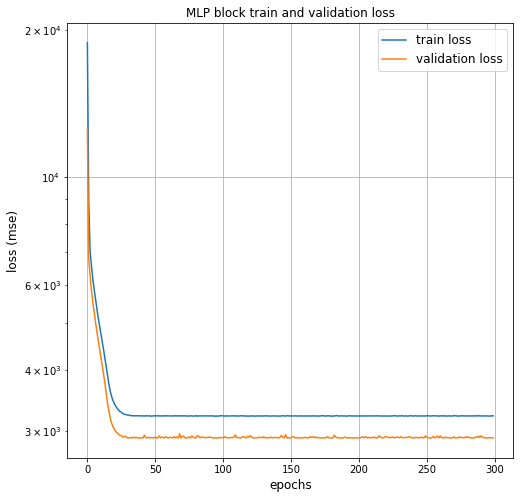

In [16]:
import matplotlib.pyplot as plt
import pickle
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')

plt.xlabel('epochs')
plt.ylabel('loss (mse)')

# plt.xlim(0)
# plt.ylim(0)
# y_ticks = [10 ** i for i in range(-10, 5)]

title = 'MLP block train and validation loss'
plt.title(title)

plt.yscale('log')
plt.legend()
plt.grid()

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
pred_y = model.predict(train_X)
mean_squared_error(train_y, pred_y, multioutput='raw_values')

array([1.3725770e-03, 6.8592545e+01, 8.6413223e+03, 1.6318083e+03,
       5.7431924e+03], dtype=float32)

In [8]:
model.evaluate(train_X, train_y)

8000/8000 [==============================] - 0s 40us/sample - loss: 3216.9855 - mse: 3216.9856


[3216.9854990234376, 3216.9856]

In [9]:
pred_y = model.predict(valid_X)
mean_squared_error(valid_y, pred_y, multioutput='raw_values')

array([1.3586880e-03, 6.9668663e+01, 8.6411465e+03, 2.1136345e+02,
       5.6007656e+03], dtype=float32)

In [10]:
model.evaluate(valid_X, valid_y)

2000/2000 [==============================] - 0s 43us/sample - loss: 2904.5905 - mse: 2904.5906


[2904.59053125, 2904.5906]

In [11]:
np.random.seed(123)

data_size = 2000
a_test = np.random.uniform(0, 100, data_size).reshape((data_size, 1))
b_test = np.random.uniform(0, 100, data_size).reshape((data_size, 1))
c_test = np.random.uniform(0, 100, data_size).reshape((data_size, 1))

answer_test = np.concatenate([a_test, b_test, c_test], axis=1)
print(answer_test.shape)
# print(answer)


df = pd.DataFrame(answer_test, columns=['a', 'b', 'c'])
df['a + 2b'] = df['a'] + 2 * df['b']
df['a * b'] = df['a'] * df['b']
df['a * b ^ 2 + c'] = df['a'] * (df['b'] ** 2) + df['c']
df['a / b + c'] = df['a'] / df['b'] + df['c']
df['(a + b) * c'] = (df['a'] + df['b']) * df['c']
df['a * b * c'] = df['a'] * df['b'] * df['c']
df = df.astype(np.float32)

(2000, 3)


In [12]:
input_columns = ['a', 'b', 'c']
test_X = df[input_columns].values

# target_columns = ['a + b', 'a * b']
target_columns = ['a + 2b', 'a * b', 'a * b ^ 2 + c', 'a / b + c', 'a * b * c'] #, '(a + b) * c'
# target_columns = ['(a + b) * c']
test_y = df[target_columns].values

In [13]:
pred_y = model.predict(test_X)
mean_squared_error(test_y, pred_y, multioutput='raw_values')

array([6.1260867e-01, 8.4625850e+06, 6.5641759e+10, 4.5359211e+04,
       3.7869167e+10], dtype=float32)

In [14]:
model.evaluate(test_X, test_y)

2000/2000 [==============================] - 0s 40us/sample - loss: 20703907561.4720 - mse: 20703909888.0000


[20703907561.472, 20703910000.0]

In [15]:
_a = [2.69e-4, 2.58e-3, 121.94, 211.05, 378.73]

In [16]:
np.mean(_a)

142.3445698

In [20]:
# print(valid_y[:5], y_pred)
# print(model.gate)
print(tf.round(model.gate))
# print(tf.sigmoid(model.gate))
# print(model.W)
print(tf.round(model.W))
# print(model.W_log)
# print(tf.multiply(model.W, -model.gate + 1))

tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [2. 1. 1. 1. 0.]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[ 1.  1.  1.  1.  1.]
 [ 2.  1.  2. -1.  1.]
 [ 0.  0.  1.  1.  1.]], shape=(3, 5), dtype=float32)


In [60]:
nans_percents = [0, 1, 2, 3, 4, 5]

In [61]:
from sklearn.metrics import mean_squared_error

In [62]:
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import pickle

for nans_percent in nans_percents:
    train, valid = train_test_split(df, test_size=0.2, random_state=123)
    input_columns = ['a', 'b', 'c']
    train_X = train[input_columns].values
    valid_X = valid[input_columns].values

    target_columns = ['a + 2b', 'a * b', 'a * b ^ 2 + c', 'a / b + c', 'a * b * c']
    train_y = train[target_columns].values
    valid_y = valid[target_columns].values
    
    c = int(train_X.shape[0] * (nans_percent / 100))
    train_X[:, 0][np.random.choice(train_X.shape[0], c, replace=False)] = 0.1
    train_X[:, 1][np.random.choice(train_X.shape[0], c, replace=False)] = 0.1
    train_X[:, 2][np.random.choice(train_X.shape[0], c, replace=False)] = 0.1
    
    ops.reset_default_graph()

    model = Block(len(input_columns), len(target_columns))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mse'])
    history = model.fit(train_X, train_y, validation_data=(valid_X, valid_y), epochs=300)
    
    import pickle
    with open('history_{}.pickle'.format(nans_percent), 'wb') as file:
        pickle.dump(history.history, file)
    
    print(nans_percent)
    pred_y = model.predict(train_X)
    _mse = mean_squared_error(train_y, pred_y, multioutput='raw_values')
    print('train ', _mse)
    _mse = model.evaluate(train_X, train_y)
    print('train ', _mse)
    
    pred_y = model.predict(valid_X)
    _mse = mean_squared_error(valid_y, pred_y, multioutput='raw_values')
    print('valid ', _mse)
    _mse = model.evaluate(valid_X, valid_y)
    print('valid ', _mse)

Train on 8000 samples, validate on 2000 samples
Epoch 1/300
8000/8000 [==============================] - 1s 103us/sample - loss: 21414.1717 - mse: 21414.1719 - val_loss: 19905.9258 - val_mse: 19905.9277
Epoch 2/300
8000/8000 [==============================] - 1s 63us/sample - loss: 19122.9585 - mse: 19122.9512 - val_loss: 9324.9510 - val_mse: 9324.9492
Epoch 3/300
8000/8000 [==============================] - 0s 58us/sample - loss: 4563.8176 - mse: 4563.8169 - val_loss: 2694.4871 - val_mse: 2694.4868
Epoch 4/300
8000/8000 [==============================] - 0s 55us/sample - loss: 2744.3086 - mse: 2744.3079 - val_loss: 1512.0684 - val_mse: 1512.0684
Epoch 5/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1624.8332 - mse: 1624.8329 - val_loss: 750.4417 - val_mse: 750.4415
Epoch 6/300
8000/8000 [==============================] - 0s 51us/sample - loss: 929.2196 - mse: 929.2195 - val_loss: 360.7724 - val_mse: 360.7723
Epoch 7/300
8000/8000 [============================

8000/8000 [==============================] - 0s 53us/sample - loss: 9.1083 - mse: 9.1083 - val_loss: 9.4417 - val_mse: 9.4417
Epoch 59/300
8000/8000 [==============================] - 0s 52us/sample - loss: 14.6861 - mse: 14.6861 - val_loss: 8.1803 - val_mse: 8.1803
Epoch 60/300
8000/8000 [==============================] - 0s 51us/sample - loss: 8.4692 - mse: 8.4692 - val_loss: 8.4030 - val_mse: 8.4030
Epoch 61/300
8000/8000 [==============================] - 0s 51us/sample - loss: 8.7090 - mse: 8.7090 - val_loss: 7.8250 - val_mse: 7.8250
Epoch 62/300
8000/8000 [==============================] - 0s 54us/sample - loss: 8.1029 - mse: 8.1029 - val_loss: 9.6493 - val_mse: 9.6493
Epoch 63/300
8000/8000 [==============================] - 0s 54us/sample - loss: 8.3493 - mse: 8.3493 - val_loss: 7.5181 - val_mse: 7.5181
Epoch 64/300
8000/8000 [==============================] - 0s 54us/sample - loss: 7.5239 - mse: 7.5239 - val_loss: 7.5016 - val_mse: 7.5016
Epoch 65/300
8000/8000 [==============

Epoch 117/300
8000/8000 [==============================] - 0s 59us/sample - loss: 0.9538 - mse: 0.9538 - val_loss: 0.8681 - val_mse: 0.8681
Epoch 118/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1.1580 - mse: 1.1580 - val_loss: 1.0416 - val_mse: 1.0416
Epoch 119/300
8000/8000 [==============================] - 0s 53us/sample - loss: 0.9913 - mse: 0.9913 - val_loss: 0.7324 - val_mse: 0.7324
Epoch 120/300
8000/8000 [==============================] - 0s 57us/sample - loss: 0.8659 - mse: 0.8659 - val_loss: 0.9661 - val_mse: 0.9661
Epoch 121/300
8000/8000 [==============================] - 0s 55us/sample - loss: 3.4470 - mse: 3.4470 - val_loss: 1.0892 - val_mse: 1.0892
Epoch 122/300
8000/8000 [==============================] - 0s 50us/sample - loss: 3.0248 - mse: 3.0248 - val_loss: 1.1548 - val_mse: 1.1548
Epoch 123/300
8000/8000 [==============================] - 0s 51us/sample - loss: 2.9134 - mse: 2.9134 - val_loss: 1.2846 - val_mse: 1.2846
Epoch 124/300
8000/8

8000/8000 [==============================] - 0s 51us/sample - loss: 0.6344 - mse: 0.6344 - val_loss: 0.7880 - val_mse: 0.7880
Epoch 176/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1.2303 - mse: 1.2303 - val_loss: 0.8095 - val_mse: 0.8095
Epoch 177/300
8000/8000 [==============================] - 0s 51us/sample - loss: 8.1663 - mse: 8.1663 - val_loss: 1.5946 - val_mse: 1.5946
Epoch 178/300
8000/8000 [==============================] - 0s 52us/sample - loss: 7.4193 - mse: 7.4193 - val_loss: 0.6139 - val_mse: 0.6139
Epoch 179/300
8000/8000 [==============================] - 0s 54us/sample - loss: 0.9166 - mse: 0.9166 - val_loss: 0.6073 - val_mse: 0.6073
Epoch 180/300
8000/8000 [==============================] - 0s 50us/sample - loss: 0.7731 - mse: 0.7731 - val_loss: 0.7186 - val_mse: 0.7186
Epoch 181/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1.6377 - mse: 1.6377 - val_loss: 0.5972 - val_mse: 0.5972
Epoch 182/300
8000/8000 [=========

8000/8000 [==============================] - 0s 55us/sample - loss: 1.1399 - mse: 1.1399 - val_loss: 0.5907 - val_mse: 0.5907
Epoch 234/300
8000/8000 [==============================] - 0s 55us/sample - loss: 0.8878 - mse: 0.8878 - val_loss: 0.4889 - val_mse: 0.4889
Epoch 235/300
8000/8000 [==============================] - 0s 53us/sample - loss: 0.5696 - mse: 0.5696 - val_loss: 0.4885 - val_mse: 0.4885
Epoch 236/300
8000/8000 [==============================] - 1s 65us/sample - loss: 0.5902 - mse: 0.5902 - val_loss: 0.5235 - val_mse: 0.5235
Epoch 237/300
8000/8000 [==============================] - 0s 53us/sample - loss: 0.8565 - mse: 0.8565 - val_loss: 0.6635 - val_mse: 0.6635
Epoch 238/300
8000/8000 [==============================] - 0s 59us/sample - loss: 2.0815 - mse: 2.0815 - val_loss: 1.8326 - val_mse: 1.8326
Epoch 239/300
8000/8000 [==============================] - 0s 55us/sample - loss: 7.6092 - mse: 7.6092 - val_loss: 0.5188 - val_mse: 0.5188
Epoch 240/300
8000/8000 [=========

8000/8000 [==============================] - 0s 52us/sample - loss: 0.7998 - mse: 0.7998 - val_loss: 0.4938 - val_mse: 0.4938
Epoch 292/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1.0294 - mse: 1.0294 - val_loss: 0.5058 - val_mse: 0.5058
Epoch 293/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1.2216 - mse: 1.2216 - val_loss: 0.4840 - val_mse: 0.4840
Epoch 294/300
8000/8000 [==============================] - 0s 47us/sample - loss: 0.7990 - mse: 0.7990 - val_loss: 0.4400 - val_mse: 0.4400
Epoch 295/300
8000/8000 [==============================] - 0s 60us/sample - loss: 0.7328 - mse: 0.7328 - val_loss: 0.4947 - val_mse: 0.4947
Epoch 296/300
8000/8000 [==============================] - 0s 51us/sample - loss: 6.9938 - mse: 6.9938 - val_loss: 0.4354 - val_mse: 0.4354
Epoch 297/300
8000/8000 [==============================] - 0s 49us/sample - loss: 0.6921 - mse: 0.6921 - val_loss: 0.7817 - val_mse: 0.7817
Epoch 298/300
8000/8000 [=========

Epoch 45/300
8000/8000 [==============================] - 0s 54us/sample - loss: 549.6328 - mse: 549.6328 - val_loss: 10.7653 - val_mse: 10.7653
Epoch 46/300
8000/8000 [==============================] - 0s 52us/sample - loss: 554.1559 - mse: 554.1559 - val_loss: 10.6656 - val_mse: 10.6656
Epoch 47/300
8000/8000 [==============================] - 0s 52us/sample - loss: 548.1436 - mse: 548.1437 - val_loss: 9.1953 - val_mse: 9.1953
Epoch 48/300
8000/8000 [==============================] - 0s 53us/sample - loss: 547.5275 - mse: 547.5275 - val_loss: 9.2835 - val_mse: 9.2835
Epoch 49/300
8000/8000 [==============================] - 0s 61us/sample - loss: 547.2656 - mse: 547.2656 - val_loss: 9.2096 - val_mse: 9.2096
Epoch 50/300
8000/8000 [==============================] - 0s 54us/sample - loss: 546.9373 - mse: 546.9371 - val_loss: 9.7458 - val_mse: 9.7458
Epoch 51/300
8000/8000 [==============================] - 0s 52us/sample - loss: 547.2937 - mse: 547.2936 - val_loss: 10.2984 - val_mse: 1

8000/8000 [==============================] - 1s 66us/sample - loss: 524.2716 - mse: 524.2718 - val_loss: 7.5431 - val_mse: 7.5431
Epoch 103/300
8000/8000 [==============================] - 0s 53us/sample - loss: 526.7084 - mse: 526.7085 - val_loss: 9.6530 - val_mse: 9.6530
Epoch 104/300
8000/8000 [==============================] - 1s 66us/sample - loss: 531.0087 - mse: 531.0087 - val_loss: 7.6369 - val_mse: 7.6369
Epoch 105/300
8000/8000 [==============================] - 0s 59us/sample - loss: 524.1836 - mse: 524.1835 - val_loss: 7.8857 - val_mse: 7.8857
Epoch 106/300
8000/8000 [==============================] - 0s 55us/sample - loss: 525.2752 - mse: 525.2752 - val_loss: 8.1347 - val_mse: 8.1347
Epoch 107/300
8000/8000 [==============================] - 0s 52us/sample - loss: 524.0469 - mse: 524.0468 - val_loss: 7.7487 - val_mse: 7.7487
Epoch 108/300
8000/8000 [==============================] - 1s 64us/sample - loss: 524.0126 - mse: 524.0127 - val_loss: 8.7297 - val_mse: 8.7297
Epoch 

Epoch 159/300
8000/8000 [==============================] - 0s 54us/sample - loss: 533.5814 - mse: 533.5814 - val_loss: 9.7535 - val_mse: 9.7535
Epoch 160/300
8000/8000 [==============================] - 0s 55us/sample - loss: 524.5844 - mse: 524.5846 - val_loss: 9.0153 - val_mse: 9.0153
Epoch 161/300
8000/8000 [==============================] - 0s 54us/sample - loss: 523.4235 - mse: 523.4236 - val_loss: 9.9364 - val_mse: 9.9364
Epoch 162/300
8000/8000 [==============================] - 0s 53us/sample - loss: 523.9403 - mse: 523.9404 - val_loss: 9.6367 - val_mse: 9.6367
Epoch 163/300
8000/8000 [==============================] - 0s 55us/sample - loss: 523.6729 - mse: 523.6729 - val_loss: 10.3840 - val_mse: 10.3840
Epoch 164/300
8000/8000 [==============================] - 0s 53us/sample - loss: 523.6171 - mse: 523.6170 - val_loss: 9.9906 - val_mse: 9.9906
Epoch 165/300
8000/8000 [==============================] - 0s 61us/sample - loss: 524.9188 - mse: 524.9191 - val_loss: 10.0759 - val_m

8000/8000 [==============================] - 0s 52us/sample - loss: 523.9708 - mse: 523.9708 - val_loss: 9.8029 - val_mse: 9.8029
Epoch 216/300
8000/8000 [==============================] - 0s 54us/sample - loss: 523.4215 - mse: 523.4215 - val_loss: 9.7130 - val_mse: 9.7130
Epoch 217/300
8000/8000 [==============================] - 0s 50us/sample - loss: 523.5173 - mse: 523.5175 - val_loss: 10.1123 - val_mse: 10.1123
Epoch 218/300
8000/8000 [==============================] - 0s 50us/sample - loss: 523.4791 - mse: 523.4791 - val_loss: 9.7977 - val_mse: 9.7977
Epoch 219/300
8000/8000 [==============================] - 0s 51us/sample - loss: 524.5467 - mse: 524.5466 - val_loss: 10.5507 - val_mse: 10.5507
Epoch 220/300
8000/8000 [==============================] - 0s 56us/sample - loss: 525.2486 - mse: 525.2485 - val_loss: 9.6829 - val_mse: 9.6829
Epoch 221/300
8000/8000 [==============================] - 0s 55us/sample - loss: 523.6166 - mse: 523.6165 - val_loss: 10.7854 - val_mse: 10.7854


8000/8000 [==============================] - 0s 53us/sample - loss: 523.4708 - mse: 523.4708 - val_loss: 10.1830 - val_mse: 10.1830
Epoch 272/300
8000/8000 [==============================] - 0s 52us/sample - loss: 523.5314 - mse: 523.5313 - val_loss: 9.7981 - val_mse: 9.7981
Epoch 273/300
8000/8000 [==============================] - 0s 54us/sample - loss: 523.4505 - mse: 523.4507 - val_loss: 11.1063 - val_mse: 11.1063
Epoch 274/300
8000/8000 [==============================] - 0s 55us/sample - loss: 524.8967 - mse: 524.8968 - val_loss: 10.3685 - val_mse: 10.3685
Epoch 275/300
8000/8000 [==============================] - 0s 52us/sample - loss: 523.8192 - mse: 523.8193 - val_loss: 10.2181 - val_mse: 10.2181
Epoch 276/300
8000/8000 [==============================] - 0s 52us/sample - loss: 523.5356 - mse: 523.5355 - val_loss: 9.6826 - val_mse: 9.6826
Epoch 277/300
8000/8000 [==============================] - 0s 51us/sample - loss: 525.3087 - mse: 525.3085 - val_loss: 9.9115 - val_mse: 9.911

Epoch 24/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1037.7049 - mse: 1037.7051 - val_loss: 9.9263 - val_mse: 9.9263
Epoch 25/300
8000/8000 [==============================] - 0s 62us/sample - loss: 1037.0221 - mse: 1037.0222 - val_loss: 10.5538 - val_mse: 10.5538
Epoch 26/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1038.2542 - mse: 1038.2540 - val_loss: 9.6086 - val_mse: 9.6086
Epoch 27/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1032.9979 - mse: 1032.9982 - val_loss: 9.7034 - val_mse: 9.7034
Epoch 28/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1031.2932 - mse: 1031.2931 - val_loss: 9.7393 - val_mse: 9.7393
Epoch 29/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1029.6224 - mse: 1029.6222 - val_loss: 9.8147 - val_mse: 9.8147
Epoch 30/300
8000/8000 [==============================] - 0s 48us/sample - loss: 1029.0376 - mse: 1029.0377 - val_loss: 9.5274 -

8000/8000 [==============================] - 0s 55us/sample - loss: 974.2029 - mse: 974.2028 - val_loss: 15.3243 - val_mse: 15.3243
Epoch 81/300
8000/8000 [==============================] - 0s 55us/sample - loss: 973.4677 - mse: 973.4679 - val_loss: 15.4062 - val_mse: 15.4062
Epoch 82/300
8000/8000 [==============================] - 0s 54us/sample - loss: 973.2172 - mse: 973.2173 - val_loss: 19.1488 - val_mse: 19.1488
Epoch 83/300
8000/8000 [==============================] - 0s 50us/sample - loss: 974.7871 - mse: 974.7869 - val_loss: 17.2872 - val_mse: 17.2872
Epoch 84/300
8000/8000 [==============================] - 0s 58us/sample - loss: 971.8241 - mse: 971.8240 - val_loss: 17.7076 - val_mse: 17.7076
Epoch 85/300
8000/8000 [==============================] - 0s 53us/sample - loss: 974.5371 - mse: 974.5369 - val_loss: 18.2235 - val_mse: 18.2235
Epoch 86/300
8000/8000 [==============================] - 0s 49us/sample - loss: 971.8659 - mse: 971.8657 - val_loss: 19.6918 - val_mse: 19.691

8000/8000 [==============================] - 0s 55us/sample - loss: 969.3422 - mse: 969.3421 - val_loss: 26.9045 - val_mse: 26.9045
Epoch 137/300
8000/8000 [==============================] - 0s 54us/sample - loss: 972.4464 - mse: 972.4468 - val_loss: 27.5359 - val_mse: 27.5359
Epoch 138/300
8000/8000 [==============================] - 0s 53us/sample - loss: 969.2349 - mse: 969.2350 - val_loss: 29.0215 - val_mse: 29.0215
Epoch 139/300
8000/8000 [==============================] - 0s 51us/sample - loss: 970.2341 - mse: 970.2344 - val_loss: 27.4057 - val_mse: 27.4057
Epoch 140/300
8000/8000 [==============================] - 0s 55us/sample - loss: 968.8463 - mse: 968.8463 - val_loss: 27.1904 - val_mse: 27.1904
Epoch 141/300
8000/8000 [==============================] - 0s 51us/sample - loss: 968.8040 - mse: 968.8041 - val_loss: 26.4345 - val_mse: 26.4345
Epoch 142/300
8000/8000 [==============================] - 0s 50us/sample - loss: 973.3693 - mse: 973.3697 - val_loss: 26.7567 - val_mse: 

8000/8000 [==============================] - 0s 46us/sample - loss: 968.9046 - mse: 968.9047 - val_loss: 28.3127 - val_mse: 28.3127
Epoch 193/300
8000/8000 [==============================] - 0s 53us/sample - loss: 973.2541 - mse: 973.2542 - val_loss: 28.9808 - val_mse: 28.9807
Epoch 194/300
8000/8000 [==============================] - 0s 46us/sample - loss: 968.3340 - mse: 968.3337 - val_loss: 30.6365 - val_mse: 30.6365
Epoch 195/300
8000/8000 [==============================] - 0s 56us/sample - loss: 970.5483 - mse: 970.5483 - val_loss: 29.5963 - val_mse: 29.5963
Epoch 196/300
8000/8000 [==============================] - 0s 54us/sample - loss: 969.6667 - mse: 969.6667 - val_loss: 31.9004 - val_mse: 31.9004
Epoch 197/300
8000/8000 [==============================] - 0s 53us/sample - loss: 972.8458 - mse: 972.8458 - val_loss: 29.8471 - val_mse: 29.8471
Epoch 198/300
8000/8000 [==============================] - 0s 54us/sample - loss: 968.6117 - mse: 968.6119 - val_loss: 29.1916 - val_mse: 

8000/8000 [==============================] - 0s 52us/sample - loss: 970.5423 - mse: 970.5424 - val_loss: 31.3456 - val_mse: 31.3456
Epoch 249/300
8000/8000 [==============================] - 0s 52us/sample - loss: 968.6534 - mse: 968.6530 - val_loss: 33.0870 - val_mse: 33.0870
Epoch 250/300
8000/8000 [==============================] - 0s 53us/sample - loss: 968.4464 - mse: 968.4467 - val_loss: 30.9283 - val_mse: 30.9284
Epoch 251/300
8000/8000 [==============================] - 0s 54us/sample - loss: 968.6564 - mse: 968.6567 - val_loss: 30.8755 - val_mse: 30.8755
Epoch 252/300
8000/8000 [==============================] - 0s 53us/sample - loss: 972.6417 - mse: 972.6415 - val_loss: 32.0003 - val_mse: 32.0003
Epoch 253/300
8000/8000 [==============================] - 1s 63us/sample - loss: 968.3805 - mse: 968.3808 - val_loss: 30.7273 - val_mse: 30.7273
Epoch 254/300
8000/8000 [==============================] - 1s 68us/sample - loss: 968.1226 - mse: 968.1227 - val_loss: 32.0413 - val_mse: 

8000/8000 [==============================] - 1s 83us/sample - loss: 21427.3119 - mse: 21427.3262 - val_loss: 19905.7630 - val_mse: 19905.7637
Epoch 2/300
8000/8000 [==============================] - 0s 51us/sample - loss: 19633.7152 - mse: 19633.7227 - val_loss: 9730.5169 - val_mse: 9730.5176
Epoch 3/300
8000/8000 [==============================] - 0s 51us/sample - loss: 6195.1995 - mse: 6195.2002 - val_loss: 2607.9021 - val_mse: 2607.9016
Epoch 4/300
8000/8000 [==============================] - 0s 56us/sample - loss: 4395.9397 - mse: 4395.9399 - val_loss: 1418.5887 - val_mse: 1418.5885
Epoch 5/300
8000/8000 [==============================] - 0s 60us/sample - loss: 3248.4020 - mse: 3248.4014 - val_loss: 652.2607 - val_mse: 652.2607
Epoch 6/300
8000/8000 [==============================] - 0s 55us/sample - loss: 2501.0888 - mse: 2501.0898 - val_loss: 282.3000 - val_mse: 282.3000
Epoch 7/300
8000/8000 [==============================] - 0s 55us/sample - loss: 2151.4042 - mse: 2151.4045 - v

Epoch 57/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1555.6046 - mse: 1555.6046 - val_loss: 12.5725 - val_mse: 12.5725
Epoch 58/300
8000/8000 [==============================] - 0s 50us/sample - loss: 1548.8048 - mse: 1548.8051 - val_loss: 13.4356 - val_mse: 13.4356
Epoch 59/300
8000/8000 [==============================] - 0s 50us/sample - loss: 1546.2148 - mse: 1546.2146 - val_loss: 13.2754 - val_mse: 13.2754
Epoch 60/300
8000/8000 [==============================] - 0s 57us/sample - loss: 1548.1047 - mse: 1548.1040 - val_loss: 13.2820 - val_mse: 13.2820
Epoch 61/300
8000/8000 [==============================] - 0s 50us/sample - loss: 1542.2021 - mse: 1542.2019 - val_loss: 13.8293 - val_mse: 13.8293
Epoch 62/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1538.4526 - mse: 1538.4528 - val_loss: 15.5956 - val_mse: 15.5956
Epoch 63/300
8000/8000 [==============================] - 0s 57us/sample - loss: 1536.8084 - mse: 1536.8086 - val_loss

8000/8000 [==============================] - 0s 51us/sample - loss: 1507.2833 - mse: 1507.2830 - val_loss: 51.8153 - val_mse: 51.8153
Epoch 113/300
8000/8000 [==============================] - 0s 60us/sample - loss: 1507.9697 - mse: 1507.9694 - val_loss: 53.4122 - val_mse: 53.4122
Epoch 114/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1507.7561 - mse: 1507.7563 - val_loss: 54.9368 - val_mse: 54.9368
Epoch 115/300
8000/8000 [==============================] - 0s 56us/sample - loss: 1507.2890 - mse: 1507.2889 - val_loss: 56.2259 - val_mse: 56.2259
Epoch 116/300
8000/8000 [==============================] - 0s 50us/sample - loss: 1508.9383 - mse: 1508.9380 - val_loss: 55.3328 - val_mse: 55.3328
Epoch 117/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1507.7821 - mse: 1507.7826 - val_loss: 53.1285 - val_mse: 53.1285
Epoch 118/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1508.4207 - mse: 1508.4209 - val_loss: 56.75

8000/8000 [==============================] - 0s 50us/sample - loss: 1505.7436 - mse: 1505.7437 - val_loss: 62.7456 - val_mse: 62.7456
Epoch 168/300
8000/8000 [==============================] - 0s 47us/sample - loss: 1505.0362 - mse: 1505.0361 - val_loss: 63.1383 - val_mse: 63.1383
Epoch 169/300
8000/8000 [==============================] - 0s 56us/sample - loss: 1505.3326 - mse: 1505.3323 - val_loss: 63.0279 - val_mse: 63.0279
Epoch 170/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1504.2264 - mse: 1504.2262 - val_loss: 66.9085 - val_mse: 66.9085
Epoch 171/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1508.7114 - mse: 1508.7112 - val_loss: 61.9064 - val_mse: 61.9063
Epoch 172/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1505.0798 - mse: 1505.0798 - val_loss: 66.4510 - val_mse: 66.4511
Epoch 173/300
8000/8000 [==============================] - 0s 59us/sample - loss: 1506.8237 - mse: 1506.8241 - val_loss: 62.19

8000/8000 [==============================] - 0s 56us/sample - loss: 1504.9392 - mse: 1504.9391 - val_loss: 66.9045 - val_mse: 66.9045
Epoch 223/300
8000/8000 [==============================] - 0s 48us/sample - loss: 1502.6123 - mse: 1502.6125 - val_loss: 68.2240 - val_mse: 68.2240
Epoch 224/300
8000/8000 [==============================] - 0s 57us/sample - loss: 1502.6813 - mse: 1502.6820 - val_loss: 65.7804 - val_mse: 65.7805
Epoch 225/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1503.6314 - mse: 1503.6315 - val_loss: 68.0328 - val_mse: 68.0328
Epoch 226/300
8000/8000 [==============================] - 0s 58us/sample - loss: 1506.9122 - mse: 1506.9119 - val_loss: 70.2630 - val_mse: 70.2630
Epoch 227/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1502.7903 - mse: 1502.7900 - val_loss: 68.4214 - val_mse: 68.4214
Epoch 228/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1502.9130 - mse: 1502.9128 - val_loss: 69.64

8000/8000 [==============================] - 0s 51us/sample - loss: 1509.0210 - mse: 1509.0216 - val_loss: 68.9281 - val_mse: 68.9281
Epoch 278/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1503.1649 - mse: 1503.1646 - val_loss: 67.9799 - val_mse: 67.9799
Epoch 279/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1502.5472 - mse: 1502.5474 - val_loss: 69.9554 - val_mse: 69.9554
Epoch 280/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1504.0215 - mse: 1504.0211 - val_loss: 70.8548 - val_mse: 70.8548
Epoch 281/300
8000/8000 [==============================] - 1s 64us/sample - loss: 1502.4885 - mse: 1502.4884 - val_loss: 68.3669 - val_mse: 68.3669
Epoch 282/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1502.2095 - mse: 1502.2101 - val_loss: 68.7792 - val_mse: 68.7792
Epoch 283/300
8000/8000 [==============================] - 0s 55us/sample - loss: 1502.7195 - mse: 1502.7195 - val_loss: 68.35

8000/8000 [==============================] - 0s 50us/sample - loss: 1889.5065 - mse: 1889.5067 - val_loss: 12.9497 - val_mse: 12.9497
Epoch 30/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1888.9631 - mse: 1888.9624 - val_loss: 12.2003 - val_mse: 12.2003
Epoch 31/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1885.5873 - mse: 1885.5876 - val_loss: 13.0148 - val_mse: 13.0148
Epoch 32/300
8000/8000 [==============================] - 0s 56us/sample - loss: 1885.3251 - mse: 1885.3251 - val_loss: 14.2490 - val_mse: 14.2490
Epoch 33/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1884.7579 - mse: 1884.7574 - val_loss: 13.4256 - val_mse: 13.4256
Epoch 34/300
8000/8000 [==============================] - 0s 47us/sample - loss: 1880.3361 - mse: 1880.3368 - val_loss: 14.3352 - val_mse: 14.3352
Epoch 35/300
8000/8000 [==============================] - 0s 48us/sample - loss: 1877.7685 - mse: 1877.7684 - val_loss: 13.2693 - v

Epoch 85/300
8000/8000 [==============================] - 1s 69us/sample - loss: 1771.3069 - mse: 1771.3074 - val_loss: 62.3731 - val_mse: 62.3731
Epoch 86/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1768.4487 - mse: 1768.4475 - val_loss: 64.6464 - val_mse: 64.6464
Epoch 87/300
8000/8000 [==============================] - 0s 50us/sample - loss: 1769.3926 - mse: 1769.3923 - val_loss: 60.5499 - val_mse: 60.5499
Epoch 88/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1765.9266 - mse: 1765.9261 - val_loss: 62.6884 - val_mse: 62.6884
Epoch 89/300
8000/8000 [==============================] - 0s 60us/sample - loss: 1765.0811 - mse: 1765.0815 - val_loss: 66.7109 - val_mse: 66.7109
Epoch 90/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1770.2980 - mse: 1770.2979 - val_loss: 69.2243 - val_mse: 69.2243
Epoch 91/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1767.4842 - mse: 1767.4844 - val_loss

8000/8000 [==============================] - 0s 52us/sample - loss: 1757.7699 - mse: 1757.7699 - val_loss: 89.4205 - val_mse: 89.4204
Epoch 141/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1758.5066 - mse: 1758.5068 - val_loss: 86.5436 - val_mse: 86.5436
Epoch 142/300
8000/8000 [==============================] - 0s 47us/sample - loss: 1762.5053 - mse: 1762.5050 - val_loss: 86.4076 - val_mse: 86.4076
Epoch 143/300
8000/8000 [==============================] - 0s 50us/sample - loss: 1758.2593 - mse: 1758.2593 - val_loss: 87.7771 - val_mse: 87.7771
Epoch 144/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1757.8421 - mse: 1757.8418 - val_loss: 93.0756 - val_mse: 93.0756
Epoch 145/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1759.0167 - mse: 1759.0170 - val_loss: 86.6000 - val_mse: 86.6000
Epoch 146/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1761.3664 - mse: 1761.3662 - val_loss: 87.97

8000/8000 [==============================] - 0s 58us/sample - loss: 1757.2735 - mse: 1757.2738 - val_loss: 97.0303 - val_mse: 97.0303
Epoch 196/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1756.9932 - mse: 1756.9938 - val_loss: 99.3429 - val_mse: 99.3429
Epoch 197/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1760.4986 - mse: 1760.4989 - val_loss: 98.2805 - val_mse: 98.2805
Epoch 198/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1756.7155 - mse: 1756.7150 - val_loss: 95.0529 - val_mse: 95.0529
Epoch 199/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1755.7697 - mse: 1755.7692 - val_loss: 94.5427 - val_mse: 94.5427
Epoch 200/300
8000/8000 [==============================] - 0s 49us/sample - loss: 1758.7594 - mse: 1758.7595 - val_loss: 96.1024 - val_mse: 96.1023
Epoch 201/300
8000/8000 [==============================] - 1s 69us/sample - loss: 1758.6072 - mse: 1758.6073 - val_loss: 98.98

Epoch 250/300
8000/8000 [==============================] - 0s 52us/sample - loss: 1756.6846 - mse: 1756.6843 - val_loss: 101.1321 - val_mse: 101.1321
Epoch 251/300
8000/8000 [==============================] - 0s 56us/sample - loss: 1756.0733 - mse: 1756.0728 - val_loss: 102.8118 - val_mse: 102.8118
Epoch 252/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1759.8196 - mse: 1759.8198 - val_loss: 101.3359 - val_mse: 101.3359
Epoch 253/300
8000/8000 [==============================] - 0s 48us/sample - loss: 1755.4248 - mse: 1755.4248 - val_loss: 101.2138 - val_mse: 101.2138
Epoch 254/300
8000/8000 [==============================] - 0s 51us/sample - loss: 1756.1243 - mse: 1756.1248 - val_loss: 103.5833 - val_mse: 103.5833
Epoch 255/300
8000/8000 [==============================] - 0s 54us/sample - loss: 1756.8191 - mse: 1756.8185 - val_loss: 99.7319 - val_mse: 99.7319
Epoch 256/300
8000/8000 [==============================] - 0s 53us/sample - loss: 1761.0980 - mse: 176

8000/8000 [==============================] - 1s 81us/sample - loss: 21435.2938 - mse: 21435.2949 - val_loss: 19907.9006 - val_mse: 19907.9004
Epoch 2/300
8000/8000 [==============================] - 0s 50us/sample - loss: 20379.2430 - mse: 20379.2461 - val_loss: 14313.0099 - val_mse: 14313.0098
Epoch 3/300
8000/8000 [==============================] - 1s 66us/sample - loss: 7744.6760 - mse: 7744.6753 - val_loss: 2698.5316 - val_mse: 2698.5317
Epoch 4/300
8000/8000 [==============================] - 0s 55us/sample - loss: 5363.7718 - mse: 5363.7729 - val_loss: 1447.3922 - val_mse: 1447.3922
Epoch 5/300
8000/8000 [==============================] - 0s 48us/sample - loss: 4218.6878 - mse: 4218.6875 - val_loss: 652.3701 - val_mse: 652.3701
Epoch 6/300
8000/8000 [==============================] - 1s 63us/sample - loss: 3443.2933 - mse: 3443.2935 - val_loss: 277.3160 - val_mse: 277.3160
Epoch 7/300
8000/8000 [==============================] - 0s 51us/sample - loss: 3055.7459 - mse: 3055.7454 -

8000/8000 [==============================] - 0s 54us/sample - loss: 2400.0641 - mse: 2400.0642 - val_loss: 31.0432 - val_mse: 31.0432
Epoch 57/300
8000/8000 [==============================] - 0s 50us/sample - loss: 2395.8694 - mse: 2395.8682 - val_loss: 30.8466 - val_mse: 30.8466
Epoch 58/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2388.1595 - mse: 2388.1589 - val_loss: 35.0949 - val_mse: 35.0949
Epoch 59/300
8000/8000 [==============================] - 0s 58us/sample - loss: 2385.8455 - mse: 2385.8455 - val_loss: 36.7892 - val_mse: 36.7892
Epoch 60/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2383.2528 - mse: 2383.2520 - val_loss: 36.7500 - val_mse: 36.7500
Epoch 61/300
8000/8000 [==============================] - 0s 49us/sample - loss: 2376.6474 - mse: 2376.6484 - val_loss: 39.1557 - val_mse: 39.1557
Epoch 62/300
8000/8000 [==============================] - 0s 48us/sample - loss: 2373.7257 - mse: 2373.7249 - val_loss: 47.0099 - v

8000/8000 [==============================] - 0s 51us/sample - loss: 2327.2841 - mse: 2327.2839 - val_loss: 129.5877 - val_mse: 129.5877
Epoch 112/300
8000/8000 [==============================] - 0s 52us/sample - loss: 2320.0822 - mse: 2320.0825 - val_loss: 130.6700 - val_mse: 130.6700
Epoch 113/300
8000/8000 [==============================] - 0s 57us/sample - loss: 2321.8920 - mse: 2321.8926 - val_loss: 133.0155 - val_mse: 133.0155
Epoch 114/300
8000/8000 [==============================] - 0s 54us/sample - loss: 2320.1101 - mse: 2320.1099 - val_loss: 140.3087 - val_mse: 140.3087
Epoch 115/300
8000/8000 [==============================] - 0s 56us/sample - loss: 2320.4082 - mse: 2320.4089 - val_loss: 146.9244 - val_mse: 146.9244
Epoch 116/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2323.1713 - mse: 2323.1716 - val_loss: 142.0948 - val_mse: 142.0948
Epoch 117/300
8000/8000 [==============================] - 0s 54us/sample - loss: 2319.7185 - mse: 2319.7180 - val

8000/8000 [==============================] - 0s 55us/sample - loss: 2315.3146 - mse: 2315.3145 - val_loss: 156.3155 - val_mse: 156.3155
Epoch 166/300
8000/8000 [==============================] - 0s 52us/sample - loss: 2314.3836 - mse: 2314.3833 - val_loss: 159.5421 - val_mse: 159.5421
Epoch 167/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2315.2401 - mse: 2315.2402 - val_loss: 159.2560 - val_mse: 159.2560
Epoch 168/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2314.2364 - mse: 2314.2363 - val_loss: 158.9725 - val_mse: 158.9725
Epoch 169/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2312.9399 - mse: 2312.9399 - val_loss: 157.8925 - val_mse: 157.8925
Epoch 170/300
8000/8000 [==============================] - 0s 50us/sample - loss: 2314.4626 - mse: 2314.4624 - val_loss: 166.6261 - val_mse: 166.6261
Epoch 171/300
8000/8000 [==============================] - 0s 50us/sample - loss: 2316.5649 - mse: 2316.5645 - val

Epoch 220/300
8000/8000 [==============================] - 0s 52us/sample - loss: 2313.1158 - mse: 2313.1155 - val_loss: 167.7859 - val_mse: 167.7859
Epoch 221/300
8000/8000 [==============================] - 0s 54us/sample - loss: 2312.2799 - mse: 2312.2798 - val_loss: 174.5703 - val_mse: 174.5703
Epoch 222/300
8000/8000 [==============================] - 0s 55us/sample - loss: 2311.8957 - mse: 2311.8955 - val_loss: 169.0703 - val_mse: 169.0703
Epoch 223/300
8000/8000 [==============================] - 0s 51us/sample - loss: 2309.3319 - mse: 2309.3325 - val_loss: 174.3183 - val_mse: 174.3183
Epoch 224/300
8000/8000 [==============================] - 1s 65us/sample - loss: 2310.0284 - mse: 2310.0283 - val_loss: 171.3565 - val_mse: 171.3565
Epoch 225/300
8000/8000 [==============================] - 0s 50us/sample - loss: 2310.7338 - mse: 2310.7349 - val_loss: 171.8081 - val_mse: 171.8081
Epoch 226/300
8000/8000 [==============================] - 0s 54us/sample - loss: 2313.3514 - mse: 2

8000/8000 [==============================] - 0s 54us/sample - loss: 2316.6484 - mse: 2316.6477 - val_loss: 175.6595 - val_mse: 175.6595
Epoch 275/300
8000/8000 [==============================] - 0s 52us/sample - loss: 2310.3308 - mse: 2310.3313 - val_loss: 175.5664 - val_mse: 175.5665
Epoch 276/300
8000/8000 [==============================] - 0s 56us/sample - loss: 2308.8858 - mse: 2308.8857 - val_loss: 176.3708 - val_mse: 176.3708
Epoch 277/300
8000/8000 [==============================] - 0s 54us/sample - loss: 2315.6183 - mse: 2315.6177 - val_loss: 178.9791 - val_mse: 178.9791
Epoch 278/300
8000/8000 [==============================] - 0s 53us/sample - loss: 2309.0217 - mse: 2309.0217 - val_loss: 174.9162 - val_mse: 174.9162
Epoch 279/300
8000/8000 [==============================] - 0s 51us/sample - loss: 2308.3193 - mse: 2308.3193 - val_loss: 179.2049 - val_mse: 179.2049
Epoch 280/300
8000/8000 [==============================] - 0s 49us/sample - loss: 2310.7301 - mse: 2310.7300 - val

In [63]:
nans_percent

5

In [64]:
import pickle

def load_loss_data(nans_percents):
    data = {}
    for nans_percent in nans_percents:
        file_name = 'history_{}.pickle'.format(nans_percent)
        print(file_name)
        with open(file_name, 'rb') as file:
            prn_train_data = pickle.load(file)
        data[nans_percent] = prn_train_data
    
    return data

In [65]:
loss_data = load_loss_data(nans_percents)

history_0.pickle
history_1.pickle
history_2.pickle
history_3.pickle
history_4.pickle
history_5.pickle


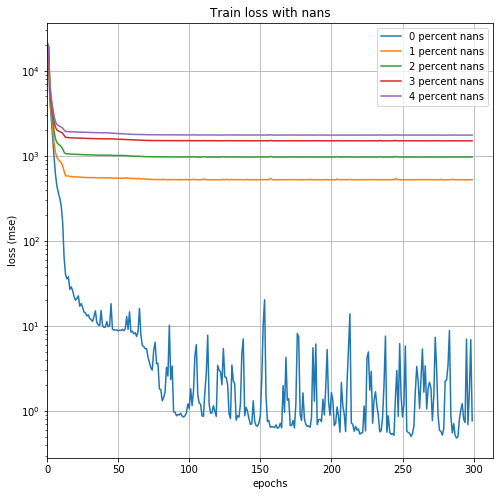

In [66]:
import matplotlib.pyplot as plt
import pickle
import os

plt.figure(figsize=(8, 8))
for nans_percent in nans_percents[:5]:
    loss_data_part = loss_data[nans_percent]
    plt.plot(loss_data_part['loss'], label='{} percent nans'.format(nans_percent))

plt.xlabel('epochs')
plt.ylabel('loss (mse)')

plt.xlim(0)
y_ticks = [10 ** i for i in range(-10, 5)]

title = 'Train loss with nans'
plt.title(title)

plt.yscale('log')
plt.legend()
plt.grid()
# plt.savefig(os.path.join(images_dir, title))

[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]


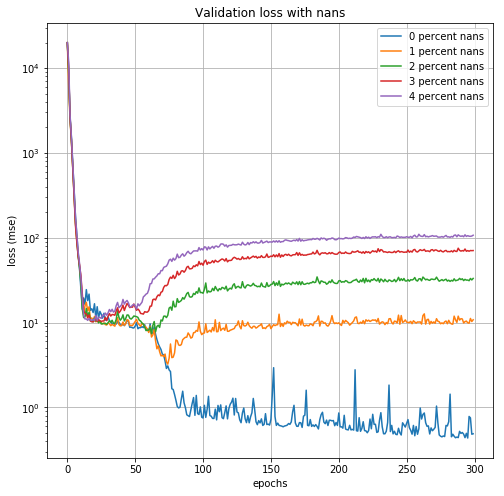

In [67]:
plt.figure(figsize=(8, 8))
for nans_percent in nans_percents[:5]:
    loss_data_part = loss_data[nans_percent]
    plt.plot(loss_data_part['val_loss'], label='{} percent nans'.format(nans_percent))

plt.xlabel('epochs')
plt.ylabel('loss (mse)')

y_ticks = [10 ** i for i in range(-10, 5)]
print(y_ticks)

title = 'Validation loss with nans'
plt.title(title)

plt.yscale('log')
plt.legend()
plt.grid()
# plt.savefig(os.path.join(images_dir, title))